# Prepayment Neural Network

Please refer to https://github.com/IBM/bank-lc-sim/blob/master/notebooks/train-on-core-features.ipynb to get the "co_clf_core.pkl"

In [36]:
import pickle, os

home_dir = "../data"

charge_off_classifier_core_pkl = os.path.join(home_dir, "co_clf_core.pkl")

with open(charge_off_classifier_core_pkl,'rb') as f:
    data_df, idx_train, idx_test, idx_validate, clf_core, core_features, analytics = pickle.load(f)

In [37]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
import gc
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
%matplotlib inline

import matplotlib.ticker as tkr
from matplotlib import rcParams

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler
import keras.backend as K
from keras.utils import np_utils
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=2)

In [38]:
df_1 = data_df['LifeOfLoan'].loc[data_df['term'] == 0]
df_2 = data_df['LifeOfLoan'].loc[data_df['term'] == 1]

In [39]:
count_1 = 0
count_2 = 0
count_3 = 0
for i in range(len(df_1)):
    # print(i)
    if df_1.iloc[i] <=18:
        count_1 += 1
    elif df_1.iloc[i] <=36:
        count_2 += 1
    else:
        count_3 +=1
print("Given 36-month loans,",count_1/len(df_1)," of them enter their final status within 18 months. ")
print("Given 36-month loans,",count_2/len(df_1)," of them enter their final status between 18 and 36 months. ")
print("Given 36-month loans,",count_3/len(df_1)," of them enter their final status over 36 months. ")

Given 36-month loans, 0.46667321811563445  of them enter their final status within 18 months. 
Given 36-month loans, 0.48254258357403157  of them enter their final status between 18 and 36 months. 
Given 36-month loans, 0.05078419831033403  of them enter their final status over 36 months. 


In [40]:
count_1 = 0
count_2 = 0
count_3 = 0
for i in range(len(df_2)):
    # print(i)
    if df_2.iloc[i] <=30:
        count_1 += 1
    elif df_2.iloc[i] <=60:
        count_2 += 1
    else:
        count_3 +=1
print("Given 60-month loans,",count_1/len(df_2)," of them enter their final status within 30 months. ")
print("Given 60-month loans,",count_2/len(df_2)," of them enter their final status between 30 and 60 months. ")
print("Given 60-month loans,",count_3/len(df_2)," of them enter their final status over 60 months. ")

Given 60-month loans, 0.7586002787731436  of them enter their final status within 30 months. 
Given 60-month loans, 0.2316140201251297  of them enter their final status between 30 and 60 months. 
Given 60-month loans, 0.009785701101726739  of them enter their final status over 60 months. 


# Data Visualization

## Chronological Output of Prepayment Ratio

In [42]:
data_df_fully_paid = data_df.loc[data_df['loan_status'].isin(['Fully Paid'])]
df_issue_month = data_df_fully_paid['issue_month'].values
df_issue_month = np.unique(df_issue_month)
data_df_fully_paid.sort_values(by=['issue_month'],ascending=True,inplace=True)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [44]:
ToPrint = []
tmp = []
for i in df_issue_month:
    # print(i)
    tmp = data_df_fully_paid.loc[data_df_fully_paid['issue_month']== i]
    num_of_loans = tmp.shape[0]

    num_of_prepayment = 0
    for j in range(len(tmp)):
        row_picked = tmp.iloc[j,:]
        if row_picked['LifeOfLoan'] != 24*row_picked['term'] + 36:
            num_of_prepayment += 1
            
    prepay_ratio_to_add = num_of_prepayment/num_of_loans
    ToPrint.append(prepay_ratio_to_add)

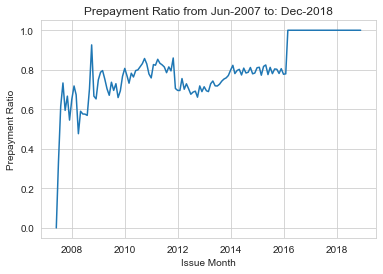

In [45]:
from datetime import datetime
import matplotlib.dates as mdates


date_index = pd.date_range(start = '05/31/2007', end = '12/30/2018', freq ='M' )
plt.plot(date_index,ToPrint)
plt.xlabel("Issue Month")
plt.ylabel("Prepayment Ratio")
plt.title("Prepayment Ratio from Jun-2007 to: Dec-2018")
plt.show()

## Number of Issued Loans 

In [46]:
data_df_charged_off = data_df.loc[data_df['LoanStatus'].isin(['1.0'])]
df_issue_month = data_df_charged_off['issue_month'].values
df_issue_month = np.unique(df_issue_month)
data_df_charged_off.sort_values(by=['issue_month'],ascending=True,inplace=True)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [47]:
ToPrint = []
tmp = []
check_total = 0
for i in df_issue_month:
    total_loans_issused = data_df.loc[data_df['issue_month'] == i]
    if total_loans_issused.shape[0] == 0:
        print("No loans issued in month:", i)
        break
    num_of_total_loans = total_loans_issused.shape[0]
    check_total += num_of_total_loans
        
    tmp = data_df_charged_off.loc[data_df_charged_off['issue_month'] == i]
    num_of_charged_off_loans = tmp.shape[0]
    
    to_add = [i,num_of_total_loans,num_of_charged_off_loans]
    ToPrint.append(to_add)

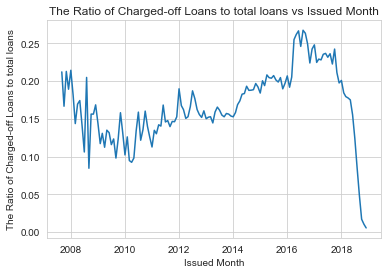

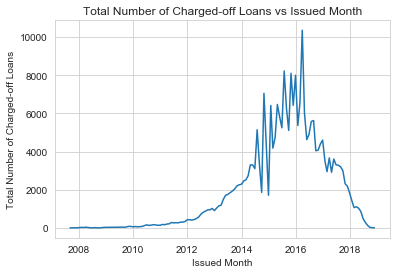

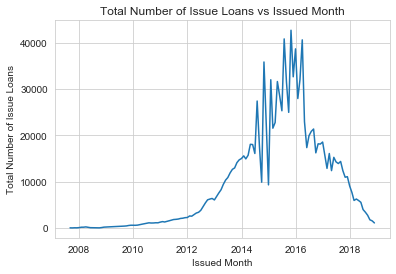

In [48]:
ToPrint_df = pd.DataFrame(ToPrint)
date_index = pd.date_range(start = '08/31/2007', end = '11/30/2018', freq ='M' )
plt.plot(date_index,ToPrint_df.iloc[:,2]/ToPrint_df.iloc[:,1])
plt.xlabel("Issued Month")
plt.ylabel("The Ratio of Charged-off Loans to total loans")
plt.title("The Ratio of Charged-off Loans to total loans vs Issued Month")
plt.show()

plt.plot(date_index,ToPrint_df.iloc[:,2])
plt.xlabel("Issued Month")
plt.ylabel("Total Number of Charged-off Loans")
plt.title("Total Number of Charged-off Loans vs Issued Month")
plt.show()

plt.plot(date_index,ToPrint_df.iloc[:,1])
plt.xlabel("Issued Month")
plt.ylabel("Total Number of Issue Loans")
plt.title("Total Number of Issue Loans vs Issued Month")
plt.show()

# Minimum Features

Feb 25th. Do not consider the interest change.

In [49]:
import pandas as pd
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler
import keras.backend as K
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=2)

### Remarks: For convenience, we did some data cleaning and generate another back-up file.  You need to redirect to "../data/data_df_backup" for the backup csv file.

In [66]:
data_df = pd.read_csv("../data/data_df_backup.csv")

In [67]:
LifeOfLoan = data_df['LifeOfLoan'].unique()

In [68]:
features_to_delete = []
count = 0
for i in range(data_df.shape[1]):
    if data_df.iloc[:,i].dtype != "float64":
        features_to_delete.append(data_df.iloc[:,i].name)
        count += 1
        # print(count)

In [69]:
minimal_feature = ['loan_amnt', 'term', 'emp_length', 'annual_inc', 'dti', \
                   'earliest_cr_line_age', 'home_ownership_ANY', 'home_ownership_MORTGAGE',\
                   'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', \
                   'verification_status_Not Verified', 'verification_status_Source Verified', 'verification_status_Verified', \
                   'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', \
                   'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', \
                   'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding',\
                   'LifeOfLoan']

In [70]:
features_to_delete = []
count = 0
for i in range(data_df.shape[1]):
    if data_df.iloc[:,i].dtype != "float64":
        features_to_delete.append(data_df.iloc[:,i].name)
        count += 1

In [71]:
df_36m=data_df[ data_df['term'].isin([0.0]) ]
df_60m=data_df[ data_df['term'].isin([1.0]) ]
data_df_36m_minimal = df_36m.loc[:,minimal_feature]
data_df_60m_minimal = df_60m.loc[:,minimal_feature]

In [72]:
data_df_36m_minimal.shape

(987059, 30)

In [73]:
y1 = data_df_36m_minimal['LifeOfLoan'].values
y2 = data_df_60m_minimal['LifeOfLoan'].values

for i in range(len(y1)):
    if float(y1[i]) <= 18:
        y1[i] = 0
    elif float(y1[i]) <= 36:
        y1[i] = 1
    else:
        y1[i] = 2


for i in range(len(y2)):
    if float(y2[i]) <= 30:
        y2[i] = 0
    elif float(y2[i]) <= 60:
        y2[i] = 1
    else:
        y2[i] = 2

In [74]:
y_36m_minimal = pd.DataFrame(y1)
y_60m_minimal = pd.DataFrame(y2)

Remarks : Drop X index: X->array->dataframe

In [75]:
X_36m_minimal = data_df_36m_minimal.drop('LifeOfLoan',axis = 1)
X_36m_minimal = X_36m_minimal.values
X_36m_minimal = pd.DataFrame(X_36m_minimal)
print("Size of 36m",X_36m_minimal.shape)
# y_36m_minimal is given above.
X_train_36m, X_test_36m, y_train_36m, y_test_36m = train_test_split(X_36m_minimal, y_36m_minimal, test_size=0.2,random_state = 42)

Size of 36m (987059, 29)


In [76]:
encoder = LabelEncoder()
encoder.fit(y_train_36m)
encoder_y_36m = encoder.transform(y_train_36m)
dummy_y_36m = np_utils.to_categorical(encoder_y_36m)

In [77]:
X_60m_minimal = data_df_60m_minimal.drop('LifeOfLoan',axis = 1)
X_60m_minimal = X_60m_minimal.values
X_60m_minimal = pd.DataFrame(X_60m_minimal)
print("Size of 60m",X_60m_minimal.shape)
# y_36m_minimal is given above.
X_train_60m, X_test_60m, y_train_60m, y_test_60m = train_test_split(X_60m_minimal, y_60m_minimal, test_size=0.2,random_state = 42)

Size of 60m (314234, 29)


In [78]:
encoder = LabelEncoder()
encoder.fit(y_train_60m)
encoder_y_60m = encoder.transform(y_train_60m)
dummy_y_60m = np_utils.to_categorical(encoder_y_60m)

In [79]:
model_36m = Sequential()
model_36m.add(Dense(128, input_dim=29, activation="relu")) 
model_36m.add(Dense(64,   activation="tanh"))
model_36m.add(Dense(32,  activation = 'tanh'))
model_36m.add(Dense(3,  activation = 'softmax'))
model_36m.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model_36m.fit(X_train_36m,dummy_y_36m,epochs = 5, validation_split = .2,callbacks = [early_stopping_monitor])

Train on 631717 samples, validate on 157930 samples
Epoch 1/5
631717/631717 [==============================] - 19s 30us/step - loss: nan - acc: 0.4663 - val_loss: nan - val_acc: 0.4670
Epoch 2/5
631717/631717 [==============================] - 18s 29us/step - loss: nan - acc: 0.4663 - val_loss: nan - val_acc: 0.4670


In [80]:
model_60m = Sequential()
model_60m.add(Dense(128, input_dim=29, activation="relu")) 
model_60m.add(Dense(64,   activation="relu"))
model_60m.add(Dense(32,  activation = 'relu'))
model_60m.add(Dense(3,  activation = 'softmax'))
model_60m.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model_60m.fit(X_train_60m,dummy_y_60m,epochs = 5, validation_split = .2,callbacks = [early_stopping_monitor])

Train on 201109 samples, validate on 50278 samples
Epoch 1/5
201109/201109 [==============================] - 6s 31us/step - loss: nan - acc: 0.7590 - val_loss: nan - val_acc: 0.7561
Epoch 2/5
201109/201109 [==============================] - 6s 29us/step - loss: nan - acc: 0.7590 - val_loss: nan - val_acc: 0.7561
